In [1]:
import pickle
import pprint
from datetime import datetime
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pytz
import seaborn as sns
from omegaconf import OmegaConf
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


exp_number: '001'
run_time: base
data:
  input_root: ../../data/input
  train_path: ../../data/input/train_features.csv
  test_path: ../../data/input/test_features.csv
  sample_submission_path: ../../data/input/sample_submission.csv
  output_root: ../../data/output
  results_root: ../../results
  results_path: ../../results/001/base
seed: 319
n_splits: 5
lgb:
  params:
    objective: regression_l1
    metric: mae
    verbosity: -1
    boosting_type: gbdt
    learning_rate: 0.01
    num_leaves: 31
    min_child_samples: 20
    max_depth: -1
    subsample_freq: 0
    bagging_seed: 0
    feature_fraction: 0.9
    bagging_fraction: 0.9
    bagging_freq: 1
    reg_alpha: 0.1
    reg_lambda: 0.1
  early_stopping_rounds: 100
  log_evaluation_period: 500
  num_boost_round: 100000



### データの読み込み

In [2]:
# データの読み込み
train = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
sample_submission = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)

# データの結合(label encoding用)
train_test = pl.concat([train, test], how="diagonal")

# scene列を作成 → これでGroupKFoldする
train = train.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))
test = test.with_columns(pl.col("ID").str.split("_").list[0].alias("scene"))

# CV
gkf = GroupKFold(n_splits=cfg.n_splits)


In [3]:
# ラベルエンコーディング
le = LabelEncoder()
le.fit(train_test["gearShifter"].fill_null(""))
train = train.with_columns(
    pl.Series(le.transform(train["gearShifter"].fill_null(""))).cast(pl.Int16).alias("gearShifter")
)
test = test.with_columns(
    pl.Series(le.transform(test["gearShifter"].fill_null(""))).cast(pl.Int16).alias("gearShifter")
)



In [4]:
train_use_cols = [
    "vEgo",
    "aEgo",
    "steeringAngleDeg",
    "steeringTorque",
    "brake",
    "brakePressed",
    "gas",
    "gasPressed",
    "gearShifter",
    "leftBlinker",
    "rightBlinker",
]

group_cols = ["scene"]

target_cols = [
    "x_0",
    "y_0",
    "z_0",
    "x_1",
    "y_1",
    "z_1",
    "x_2",
    "y_2",
    "z_2",
    "x_3",
    "y_3",
    "z_3",
    "x_4",
    "y_4",
    "z_4",
    "x_5",
    "y_5",
    "z_5",
]


In [5]:
x_train = train.select(train_use_cols).to_pandas()
group = train.select(group_cols).to_pandas()
x_test = test.select(train_use_cols).to_pandas()


### 学習

In [6]:
# 学習関数
def lgb_cv_train(x_train, y_train, group):
    # 学習設定
    lgb_data = lgb.Dataset(
        x_train,
        label=y_train,
        # categorical_feature=cfg.categorical_features,
    )
    callbacks = [
        lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
        lgb.log_evaluation(cfg.lgb.log_evaluation_period),
    ]

    # 学習
    cv_results = lgb.cv(
        dict(cfg.lgb.params),
        lgb_data,
        folds=gkf.split(x_train, y_train, group),
        num_boost_round=cfg.lgb.num_boost_round,
        callbacks=callbacks,
        return_cvbooster=True,
        seed=cfg.seed,
    )

    return cv_results


# log 関数
def log_cv_results(cv_results, target_col):
    cvbooster = cv_results["cvbooster"]
    best_iteration = cvbooster.best_iteration
    best_score = cv_results["valid l1-mean"][best_iteration - 1]
    best_score_stdv = cv_results["valid l1-stdv"][best_iteration - 1]

    with open(f"{cfg.data.results_path}/{target_col}/log.txt", "w") as log_file:
        log_file.write("====== CV Score ======\n")
        log_file.write(f"best_iteration: {best_iteration}\n")
        log_file.write(f"best_score: {best_score}\n")
        log_file.write(f"best_score_stdv: {best_score_stdv}\n")

        log_file.write("\n====== params ======\n")
        log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

        log_file.write("\n====== feature name ======\n")
        log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


In [7]:
# 実験結果格納用のディレクトリを作成
japan_tz = pytz.timezone("Asia/Tokyo")
cfg.run_time = datetime.now(japan_tz).strftime("%Y%m%d_%H%M%S")
create_dir(cfg.data.results_path)

# cv, predsリスト
cv_scores = []
target_preds = []

for target_col in target_cols:
    y_train = train.select(target_col).to_pandas()
    # 学習
    cv_results = lgb_cv_train(x_train, y_train, group)

    # 学習モデル保存
    cvbooster = cv_results["cvbooster"]
    create_dir(f"{cfg.data.results_path}/{target_col}")
    with open(f"{cfg.data.results_path}/{target_col}/model.pkl", "wb") as f:
        pickle.dump(cvbooster, f)

    # log
    log_cv_results(cv_results, target_col)

    # CV用のスコアを保存
    best_iteration = cv_results["cvbooster"].best_iteration
    best_score = cv_results["valid l1-mean"][best_iteration - 1]
    cv_scores.append(best_score)

    # テストコードの推論
    x_test = test.select(train_use_cols).to_pandas()
    y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
    y_pred = np.mean(y_preds, axis=0)
    target_preds.append(y_pred)

# # モデルのロード
# with open(f"{cfg.data.results_path}/model.pkl", "rb") as f:
#     loaded_cvbooster = pickle.load(f)

# cv_score
cv_score = np.mean(cv_scores)
print(f"cv_score: {cv_score}")

# submission
exprs = [pl.Series(target_preds[i]).alias(target_cols[i]) for i in range(len(target_cols))]
submission = sample_submission.with_columns(exprs)
submission.write_csv(f"{cfg.data.results_path}/submission.csv")
submission.head()


Directory created: ../../results/001/20241116_025114
Training until validation scores don't improve for 100 rounds
[500]	cv_agg's valid l1: 0.0972666 + 0.00268224
[1000]	cv_agg's valid l1: 0.0676862 + 0.000880485
[1500]	cv_agg's valid l1: 0.0662516 + 0.000942344
[2000]	cv_agg's valid l1: 0.0657196 + 0.000940715
[2500]	cv_agg's valid l1: 0.0654458 + 0.000924407
[3000]	cv_agg's valid l1: 0.0653029 + 0.000923816
[3500]	cv_agg's valid l1: 0.0652004 + 0.000926445
[4000]	cv_agg's valid l1: 0.0651292 + 0.000931035
[4500]	cv_agg's valid l1: 0.0650835 + 0.000929298
[5000]	cv_agg's valid l1: 0.065049 + 0.000930734
[5500]	cv_agg's valid l1: 0.065016 + 0.000935195
[6000]	cv_agg's valid l1: 0.0649949 + 0.000930814
[6500]	cv_agg's valid l1: 0.0649863 + 0.000932301
Early stopping, best iteration is:
[6727]	cv_agg's valid l1: 0.0649775 + 0.000929816
Directory created: ../../results/001/20241116_025114/x_0
Training until validation scores don't improve for 100 rounds
[500]	cv_agg's valid l1: 0.0328037 

x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.496471,-0.034532,0.00228,3.138868,-0.055258,0.005627,4.77166,-0.088534,0.009682,6.314228,-0.053904,0.010531,7.744143,-0.082482,0.012906,8.928106,-0.142918,0.016804
0.959725,0.365662,-0.002169,1.885349,0.952218,-0.000554,2.607046,1.651927,-0.000855,2.961949,2.490926,-0.003104,3.411312,3.385349,0.006576,3.689037,4.309235,0.018699
1.604898,0.008653,-0.000823,3.184475,-0.009979,-0.002793,4.561175,-0.018426,-0.002413,5.826285,-0.045153,0.001455,6.983707,-0.081585,-0.002456,8.066543,-0.12362,-0.006034
0.92034,0.059201,-0.005111,1.745633,0.146916,-0.0099,2.468165,0.307468,-0.017483,3.191499,0.562102,-0.03097,3.773573,0.818646,-0.05236,4.365113,1.168644,-0.083579
0.852931,0.002127,-0.010853,1.51853,-0.000864,-0.023072,2.063954,0.00105,-0.036411,2.281837,-0.009308,-0.04584,2.243445,-0.022626,-0.06251,2.223554,-0.025243,-0.07809


### Feature Importance

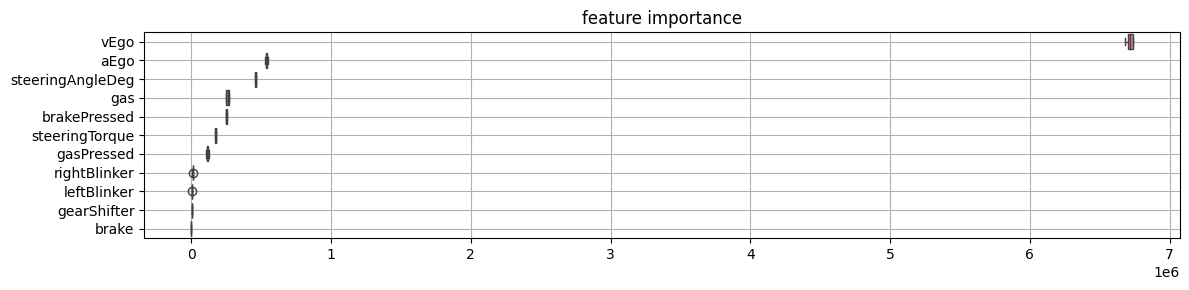

In [26]:
# # 学習済みモデルから特徴量の重要度を取り出す
# raw_importances = cvbooster.feature_importance(importance_type="gain")
# importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# # 平均値でソートする
# sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
# sorted_importance_df = importance_df.loc[:, sorted_indices]

# # 上位をプロット -> 保存
# plot_cols = sorted_importance_df.columns[:50]
# fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
# sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
# ax.grid()
# ax.set_title("feature importance")
# fig.tight_layout()
# plt.show()
# fig.savefig(f"{cfg.data.results_path}/feature_importance.png")


### oof

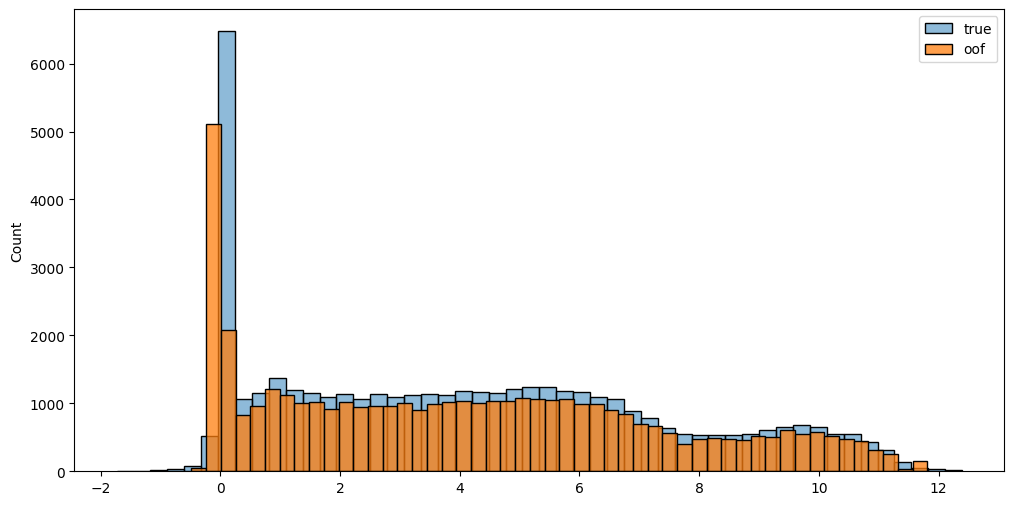

In [27]:
# oof = np.zeros(len(train))

# # 各foldで推論してoofを作成
# for i, (_, val_idx) in enumerate(gkf.split(x_train, y_train, group)):
#     x_val = x_train.iloc[val_idx]
#     model = cvbooster.boosters[i]
#     oof[val_idx] = model.predict(x_val, num_iteration=cvbooster.best_iteration)

# # oofを保存
# np.save(f"{cfg.data.results_path}/oof.npy", oof)

# fig, ax = plt.subplots(figsize=(12, 6))
# sns.histplot(y_train, bins=50, ax=ax)
# sns.histplot(oof, bins=50, ax=ax)
# plt.legend(["true", "oof"])
# plt.show()
# fig.savefig(f"{cfg.data.results_path}/oof_hist.png")


### Submission

In [9]:
# 推論
x_test = test_df.to_pandas()
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出ファイル作成
sub_df = pl.read_csv(cfg.data.sample_submission_path)
sub_df = sub_df.with_columns(pl.Series(y_pred).alias(cfg.target))
sub_df.write_csv(f"{cfg.data.results_path}/submission.csv")
sub_df.head()


id,target
i64,f64
1,4.592221
2,4.631716
3,4.692771
4,4.486453
5,4.676029


In [ ]:
# 推論
x_test = test.to_pandas()
